In [19]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from project.config.db import sync_engine
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [20]:
repos_df = pd.read_sql("""
WITH top_languages AS (
    SELECT language
    FROM repositories
    GROUP BY language
    ORDER BY COUNT(*) DESC
    LIMIT 20
)

SELECT
    r.id,
    r.full_name,
    CASE 
        WHEN r.language IN (SELECT language FROM top_languages) THEN r.language
        ELSE '_other_'
    END AS language,
    ln(r.forks_count + 0.01) as forks_count,
    r.has_downloads,
    r.has_pages,
    r.has_projects,
    r.has_wiki,
    r.has_discussions,
    r.topics,
    r.open_issues_count,
    ln(r.size + 1) as size,
    ln(r.subscribers_count + 0.01) as subscribers_count,
    CASE 
        WHEN r.organization_id IS NOT NULL THEN TRUE
        ELSE FALSE
    END AS has_org,
    ln(r.stargazers_count) as stargazers_count,
    ln(cf.size + 1) as readme_size,
    u.type_of as user_type,
    ln(u.followers + 1) as user_followers,
    u.following as user_following
FROM 
    repositories r
INNER JOIN 
    content_files cf ON r.id = cf.repository_id
INNER JOIN 
    users u on r.owner_id = u.id
ORDER BY 
    r.stargazers_count DESC;
""", sync_engine)
print(repos_df.head())
print(f'Entries: {repos_df.shape}')

         id                               full_name    language  forks_count  \
0  28457823               freeCodeCamp/freeCodeCamp  TypeScript    10.524172   
1  13491895  EbookFoundation/free-programming-books     _other_    11.021690   
2  21737465                    sindresorhus/awesome     _other_    10.229152   
3  54346799                 public-apis/public-apis      Python    10.416371   
4  60493101     jwasham/coding-interview-university     _other_    11.244078   

   has_downloads  has_pages  has_projects  has_wiki  has_discussions  \
0           True      False          True     False            False   
1           True       True         False     False            False   
2           True       True         False     False            False   
3           True      False         False     False            False   
4           True      False         False     False            False   

                                              topics  open_issues_count  \
0  [careers

In [21]:
repos_df["language"] = repos_df["language"].astype("category")
repos_df["user_type"] = repos_df["user_type"].astype("category")
repos_df = repos_df.set_index("id")
encoded_df = pd.get_dummies(repos_df, columns=["user_type", "language"])
columns_to_scale = encoded_df.select_dtypes(include=['number']).columns
encoded_df[columns_to_scale] = (encoded_df[columns_to_scale] - encoded_df[columns_to_scale].min()) / (encoded_df[columns_to_scale].max() - encoded_df[columns_to_scale].min())
print(f"Rescaling: {columns_to_scale}")
encoded_df.info()

Rescaling: Index(['forks_count', 'open_issues_count', 'size', 'subscribers_count',
       'stargazers_count', 'readme_size', 'user_followers', 'user_following'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 95126 entries, 28457823 to 26359428
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   full_name                  95126 non-null  object 
 1   forks_count                95126 non-null  float64
 2   has_downloads              95126 non-null  bool   
 3   has_pages                  95126 non-null  bool   
 4   has_projects               95126 non-null  bool   
 5   has_wiki                   95126 non-null  bool   
 6   has_discussions            95126 non-null  bool   
 7   topics                     95126 non-null  object 
 8   open_issues_count          95126 non-null  float64
 9   size                       95126 non-null  float64
 10  subscribers_count        

In [22]:
X = encoded_df.sample(frac=0.15)  # subset 
repo_names = list(X["full_name"])
repo_topics = list(X["topics"])
X = X.drop("full_name", axis=1)
X = X.drop("topics", axis=1)
X.shape

(14269, 36)

In [23]:
tsne = TSNE(random_state=0, max_iter=1_000)
tsne_results = tsne.fit_transform(X)

In [24]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne["repo_name"] = list(repo_names)
df_tsne["topics"] = list(repo_topics)
df_tsne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14269 entries, 0 to 14268
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TSNE1      14269 non-null  float32
 1   TSNE2      14269 non-null  float32
 2   repo_name  14269 non-null  object 
 3   topics     14269 non-null  object 
dtypes: float32(2), object(2)
memory usage: 334.6+ KB


(np.float64(-115.87827339172364),
 np.float64(122.4675449371338),
 np.float64(-116.89054298400879),
 np.float64(109.81950569152832))

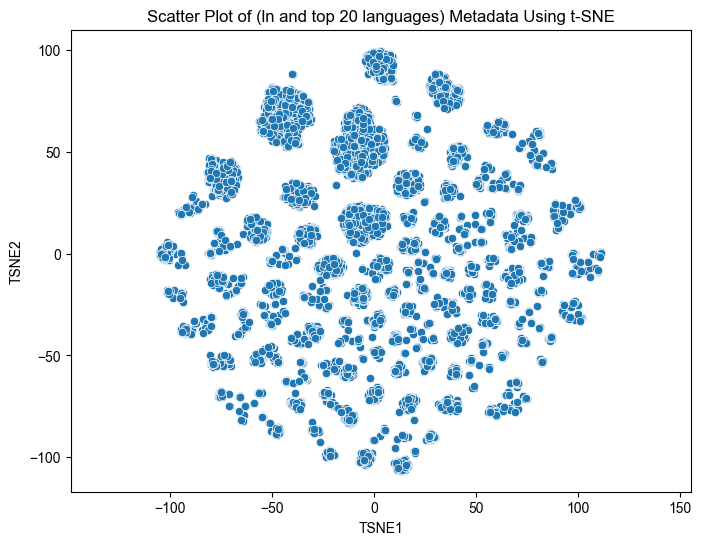

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2')
plt.title('Scatter Plot of (ln and top 20 languages) Metadata Using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [35]:
n_clusters=10
distance_threshold=None
cluster = AgglomerativeClustering(
    distance_threshold=distance_threshold, n_clusters=n_clusters
)
cluster_labels = cluster.fit_predict(X)
cluster_labels

array([1, 8, 8, ..., 3, 0, 0])

In [36]:
df_tsne['cluster'] = cluster_labels
# df_tsne['cluster'] = df_tsne["cluster"].astype("category")
df_tsne['language_python'] = list(X['language_Python'])
df_tsne['language_ts'] = list(X['language_TypeScript'])
df_tsne['language_js'] = list(X['language_JavaScript'])
df_tsne['stars'] = list(X['stargazers_count'])
df_tsne['size'] = list(X['size'])
df_tsne['subscribers'] = list(X['subscribers_count'])
df_tsne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14269 entries, 0 to 14268
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TSNE1            14269 non-null  float32
 1   TSNE2            14269 non-null  float32
 2   repo_name        14269 non-null  object 
 3   topics           14269 non-null  object 
 4   cluster          14269 non-null  int64  
 5   language_python  14269 non-null  bool   
 6   language_ts      14269 non-null  bool   
 7   language_js      14269 non-null  bool   
 8   stars            14269 non-null  float64
 9   size             14269 non-null  float64
 10  subscribers      14269 non-null  float64
dtypes: bool(3), float32(2), float64(3), int64(1), object(2)
memory usage: 822.3+ KB


(np.float64(-115.87827339172364),
 np.float64(122.4675449371338),
 np.float64(-116.89054298400879),
 np.float64(109.81950569152832))

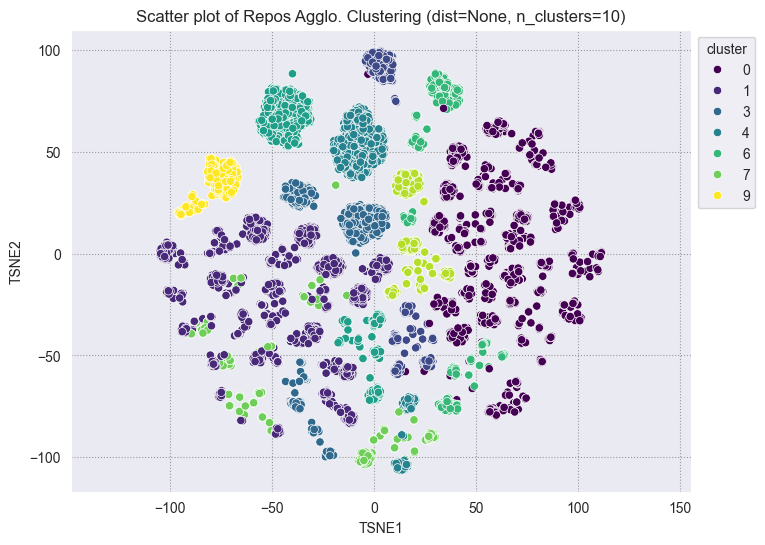

In [37]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f'Scatter plot of Repos Agglo. Clustering (dist={distance_threshold}, n_clusters={n_clusters})');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

(np.float64(-115.87827339172364),
 np.float64(122.4675449371338),
 np.float64(-116.89054298400879),
 np.float64(109.81950569152832))

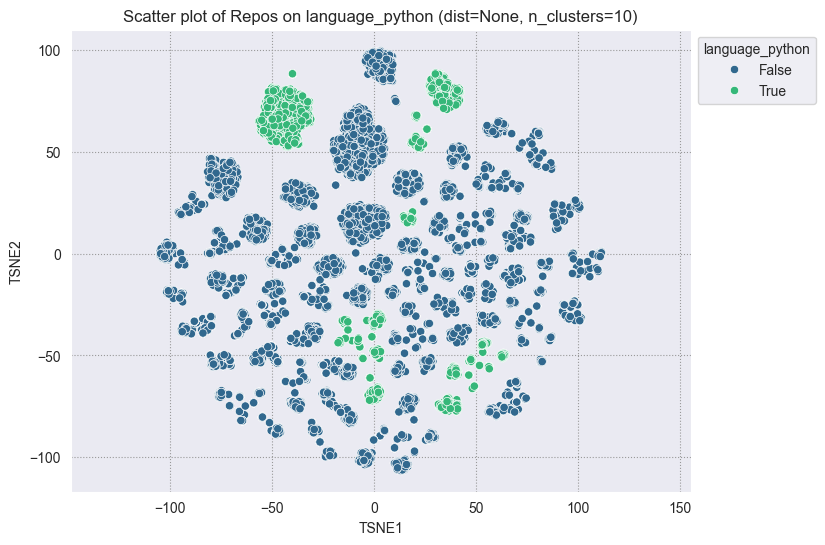

In [38]:
HUE="language_python"
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue=HUE, palette='viridis')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f'Scatter plot of Repos on {HUE} (dist={distance_threshold}, n_clusters={n_clusters})');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [30]:
def show_names(cluster_id, df=df_tsne, limit=20):
    cluster_df = df[df['cluster'] == cluster_id]
    top_repos = cluster_df['repo_name'].sort_values().head(limit)
    for repo in top_repos:
        print(f'Repo: {repo} lang: {}')
df_tsne['cluster'].value_counts()

cluster
43    962
0     946
17    655
9     550
13    512
5     427
12    400
1     399
6     395
7     384
39    367
8     362
14    335
10    328
2     316
16    313
27    307
35    291
23    291
19    271
24    270
18    269
36    251
15    246
22    239
20    231
4     221
11    209
25    207
31    200
21    196
28    190
26    188
42    187
30    187
29    183
33    181
34    179
37    171
3     169
45    156
40    138
32    136
38    133
41    132
44    130
48    123
47    119
46    118
49     99
Name: count, dtype: int64

In [33]:
show_names(16, limit=50)

Repo: 40t/go-sniffer
Repo: BurntSushi/toml
Repo: Calcium-Ion/new-api
Repo: Clivern/Peanut
Repo: D3vd/Meme_Api
Repo: Delta456/box-cli-maker
Repo: EgeBalci/sgn
Repo: EndlessCheng/codeforces-go
Repo: EwenQuim/entropy
Repo: Finb/bark-server
Repo: Forceu/Gokapi
Repo: Foxboron/sbctl
Repo: GeertJohan/go.rice
Repo: Hoshinonyaruko/Gensokyo
Repo: JFryy/qq
Repo: KathanP19/Gxss
Repo: KingOfBugbounty/KingOfBugBountyTips
Repo: Licoy/fetch-github-hosts
Repo: MaxHalford/eaopt
Repo: MrEmpy/mantra
Repo: Roverr/rtsp-stream
Repo: Snawoot/opera-proxy
Repo: SpenserCai/DRat
Repo: SpenserCai/GoWxDump
Repo: TannerGabriel/learning-go
Repo: Terry-Mao/bfs
Repo: XiaoMengXinX/Music163bot-Go
Repo: ZxwyWebSite/lx-source
Repo: aQuaYi/LeetCode-in-Go
Repo: abice/go-enum
Repo: abiosoft/ishell
Repo: aceberg/WatchYourLAN
Repo: aceld/zinx
Repo: acheong08/ChatGPT-API-server
Repo: adalkiran/webrtc-nuts-and-bolts
Repo: adelolmo/hd-idle
Repo: ajermakovics/jvm-mon
Repo: akavel/up
Repo: akutz/memconn
Repo: alash3al/redix
Repo: al

In [72]:
topics_df = pd.read_sql("""
WITH top_topics AS (
  SELECT 
    topic,
    COUNT(*) as occurrence_count
  FROM 
    repositories,
    jsonb_array_elements_text(topics::jsonb) AS topic
  WHERE 
    topics IS NOT NULL
  GROUP BY 
    topic
  ORDER BY 
    occurrence_count DESC
)
SELECT * FROM top_topics;
""", sync_engine)
print(topics_df.head(30))
print(f'Entries: {topics_df.shape}')

               topic  occurrence_count
0             python              4729
1         javascript              3947
2      hacktoberfest              3839
3            android              2855
4              react              2564
5      deep-learning              2111
6             golang              2099
7   machine-learning              2037
8               java              1961
9         typescript              1927
10                go              1701
11               ios              1700
12             linux              1631
13              rust              1589
14            nodejs              1507
15               php              1439
16           pytorch              1434
17            docker              1373
18             swift              1263
19          security              1259
20               vue              1243
21           awesome              1136
22             macos              1115
23      awesome-list              1090
24           windows     